## Helpers

In [1]:
import pandas as pd
import numpy as np
import time
from talib import BBANDS, RSI

OHCL + BB + BB width + RSI

In [345]:
def make_observations(df: pd.DataFrame, 
                      size: int, 
                      future: int
                     ):
    """
    Size is the number of candles used as a base for prophecy.
    Future=n sets as y the n-th price value since last know price.
    Default walues for BB and RSI
    """
    assert future >0, 'Future must be >= 1'
    assert df.shape[0] >= size+future+1+22, 'Not efficient number of records' # 40 to assure BB, RSI
    assert future < size, 'Well, keep future lower than size'
    
    # determine how many records
    output = []
    n = df.shape[0]-(size+future+1+20)
#     n = 2
    for i in range(int(n)):
        arr = df.iloc[i : i+size+future+20, :][['close', 'high', 'low', 'open']]
        price, rsi, bbw, y, M, m = prepare_price(arr, size)
        output.append([price, rsi, bbw, M, m, y])
        
    df = pd.DataFrame(output, columns=['price', 'rsi', 'bbw', 'M', 'm', 'y'])
    return df
    

def prepare_price(arr, size):
    uband, sma, lband = BBANDS(arr.close.values, timeperiod=20, nbdevup=2, nbdevdn=2)
    arr['bbup'] = uband
    arr['sma'] = sma
    arr['bblow'] = lband
    
    # Target
    y = arr.close.values[-1]
    
    # Make RSI
    rsi = RSI(arr.close.values, timeperiod=14)[20:20+size]
    rsi = rsi.reshape((rsi.size, 1))
    
    # Add BB width
    bbw = uband - lband
    bbw = bbw[20:20+size] / np.max(bbw[20:20+size])
    bbw = bbw.reshape((bbw.size, 1))
    
    # Normalize price
    arr = arr.iloc[20:20+size,:]
    M = np.max(np.max(arr.values))
    m = np.min(np.min(arr.values))
    d = M - m
    x = (arr.values - m)/d 
    y = (y-m)/d

    assert x.shape[0] == rsi.size, 'Price and RSI shapes differ'
    assert bbw.size == rsi.size

#     output = [np.concatenate([o, [x]]) for o, x in zip(output, rsi)]
    return x, rsi, bbw, y, M , m

                

In [386]:
size, future = 24, 3
p, tf = 'LTCUSD', '1h'

df = pd.read_pickle(f'data/{p}:{tf}_full.pkl')
df = df.sort_values(by="tstmp")

df = make_observations(df, size, future)
df.to_pickle(f'data/ta_{p}:{tf}_s:{size}f:{future}')
print(df.shape)
df.head(3)

(23022, 6)


,price,rsi,bbw,M,m,y
0,"[[0.30853817994755145, 0.3172557143213699, 0.0...","[[51.47544808375122], [51.68137072105695], [56...","[[0.9593220924537018], [0.9626577840595115], [...",3.393123,3.312825,1.042056
1,"[[0.31974643843102063, 0.5003239361727682, 0.3...","[[49.3193610974999], [54.3365186107274], [48.4...","[[0.9626577840552725], [0.9187159355223263], [...",3.393123,3.312825,1.029603
2,"[[0.5417742188925037, 0.5417742188925037, 0.42...","[[55.99240632798137], [50.063669830022995], [5...","[[0.8348461105837999], [0.8597326703543066], [...",3.399900,3.312825,0.345392


In [11]:
size, future = 24, 3
p, tf = 'LTCUSD', '1h'
df = pd.read_pickle(f'data/ta_{p}:{tf}_s:{size}f:{future}')

## Import data

# Data from influx

In [1]:
from influxdb import InfluxDBClient
influx = InfluxDBClient('0.0.0.0', 5002, 'root', 'root', 'pairs')

In [2]:
influx.drop_database('pairs')

In [3]:
influx.query('select * from BTCUSD1h')

ResultSet({'('BTCUSD1h', None)': [{'time': '2018-07-22T22:00:00Z', 'close': 7411.6, 'exchange': 'bitfinex', 'high': 7424, 'low': 7333, 'open': 7371.4, 'volume': 972.40908597}, {'time': '2018-07-22T23:00:00Z', 'close': 7397.6, 'exchange': 'bitfinex', 'high': 7411.7, 'low': 7372, 'open': 7411.7, 'volume': 310.74915439}, {'time': '2018-07-23T00:00:00Z', 'close': 7465.2, 'exchange': 'bitfinex', 'high': 7475.7, 'low': 7374, 'open': 7398.7, 'volume': 1369.61788483}, {'time': '2018-07-23T01:00:00Z', 'close': 7519.7, 'exchange': 'bitfinex', 'high': 7519.8, 'low': 7450.1, 'open': 7465.3, 'volume': 1613.66388438}, {'time': '2018-07-23T02:00:00Z', 'close': 7636, 'exchange': 'bitfinex', 'high': 7670.3, 'low': 7514.6, 'open': 7519.8, 'volume': 6036.34322652}, {'time': '2018-07-23T03:00:00Z', 'close': 7626.5, 'exchange': 'bitfinex', 'high': 7661.6215087, 'low': 7607.6, 'open': 7636.0652886, 'volume': 1874.83944561}, {'time': '2018-07-23T04:00:00Z', 'close': 7675.7, 'exchange': 'bitfinex', 'high': 77

In [25]:
size, future, step = 20, 1, 1
dfs = []

for p in ['ETHUSD', 'LTCUSD', 'NEOUSD']:
    for tf in ['1h', '3h', '6h']:
        df = pd.read_pickle(f'data/{p}:{tf}_full.pkl')
        df = df.sort_values(by="tstmp")
        df = make_observations(df, size, future, step, volume=True)
        dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df.to_pickle(f'data/change_FULL_s:{size}:f{future}:s{step}_vol.pkl')

## Models

In [4]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df[['price', 'bbw', 'rsi']], df.y.values, test_size=0.1, random_state=42)


X_train_p = np.array([x for x in X_train.price.values])
X_train_bb = np.array([x for x in X_train.bbw.values])
X_train_rsi = np.array([x for x in X_train.rsi.values])

X_test_p = np.array([x for x in X_test.price.values])
X_test_bb = np.array([x for x in X_test.bbw.values])
X_test_rsi = np.array([x for x in X_test.rsi.values])

print(X_train_p.shape, X_test_p.shape)
print(X_train_bb.shape)
print(X_train_rsi.shape)
print(X_train_p[0])

(20719, 24, 7) (2303, 24, 7)
(20719, 24, 1)
(20719, 24, 1)
[[0.87432552 0.94223664 0.2858708  0.2858708  0.98317251 0.49158625
  0.        ]
 [0.68521417 0.86555231 0.63160013 0.86555231 0.96497316 0.4857212
  0.00646924]
 [0.70698472 0.8093388  0.64329774 0.69561205 0.98771938 0.50011576
  0.01251214]
 [0.50975004 0.70828446 0.48895429 0.70828446 0.98737809 0.49980707
  0.01223606]
 [0.46490921 0.61892772 0.42754184 0.50975004 0.98427286 0.49665522
  0.00903757]
 [0.65856962 0.90649394 0.35410686 0.46458427 1.         0.51030243
  0.02060486]
 [0.49090389 0.8480059  0.30601669 0.65856962 0.99115544 0.50393373
  0.01671202]
 [0.47433228 0.58318503 0.39927262 0.5055259  0.9736229  0.49342213
  0.01322135]
 [0.48570496 0.58156036 0.47433228 0.47465721 0.96187052 0.48601364
  0.01015676]
 [0.40544636 0.48635482 0.36775407 0.48115589 0.95577959 0.47933626
  0.00289292]
 [0.42559224 0.62347679 0.38660021 0.40544636 0.90127719 0.45764694
  0.01401669]
 [0.61925266 0.7212818  0.42559224 0.425

In [325]:
X.shape

(22,)

In [13]:
from keras.models import Model
from keras.layers import Dense, Embedding, Dropout, Activation, Concatenate, Input, LSTM, CuDNNLSTM, concatenate, Reshape, TimeDistributed
from livelossplot.keras import PlotLossesCallback
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from matplotlib import pyplot as plt

def score(y, y_hat):
    return {'mse': float(mean_squared_error(y, y_hat)),
    'mae': float(mean_absolute_error(y, y_hat)),
    'r2': float(r2_score(y, y_hat))}

def ta_prophecy(input_shape,
                lstm_price = 8,
                lstm_bbw = 8,
                lstm_rsi = 8,
                loss='mean_squared_error',
                activation = 'linear',
                optimizer='sgd'):
    '''OHLC, BB, RSI, BB width'''        
    
    price_input = Input(shape=(input_shape, 7))
    bbw_input = Input(shape=(input_shape, 1))
    rsi_input = Input(shape=(input_shape, 1))
    
    lstm_price_out = LSTM(lstm_price)(price_input)
    lstm_bbw_out = LSTM(lstm_bbw)(bbw_input)
    lstm_rsi_out = LSTM(lstm_rsi)(rsi_input)
    
    merged = concatenate([lstm_price_out, lstm_bbw_out, lstm_rsi_out])
    
    output = Dense(1, activation=activation)(merged)
    
    model = Model(inputs=[price_input, bbw_input, rsi_input], outputs=output)
    model.compile(loss=loss, optimizer=optimizer)
    return model

Using TensorFlow backend.


In [14]:
model = ta_prophecy(input_shape=X_train_p[0].shape[0])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 24, 7)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 24, 1)        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 24, 1)        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 8)            512         input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LS

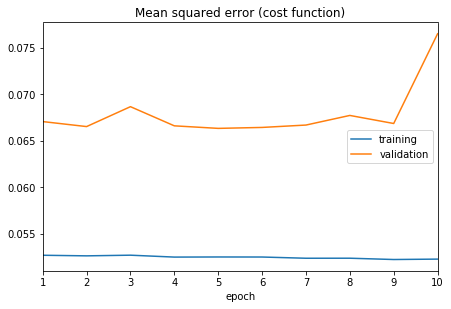

Mean squared error (cost function):
training   (min:    0.052, max:    0.053, cur:    0.052)
validation (min:    0.066, max:    0.076, cur:    0.076)


In [20]:
model.fit(
    [X_train_p, X_train_bb, X_train_rsi] , y_train,
    epochs= 10,
    batch_size = 128,
    validation_data=([X_test_p, X_test_bb, X_test_rsi], y_test),
    callbacks=[PlotLossesCallback(),
              EarlyStopping(monitor='val_loss', min_delta=0.00005, patience=15,)]
)


In [192]:
filename = f'models/size{size}future{future}_130219.h5'
model.save(filename)
print(filename)

models/size50future3_130219.h5


In [376]:
p, b, r = X_test_p[0], X_test_bb[0], X_test_rsi[0]

In [378]:
n = 20
model.predict([X_test_p[:n], X_test_bb[:n], X_test_rsi[:n]])

array([[0.780823 ],
       [0.7933253]], dtype=float32)

In [71]:
y_test[0]

3.4698

{'mse': 0.04927165887735291, 'mae': 0.16474896755367552, 'r2': 0.519844259799449}


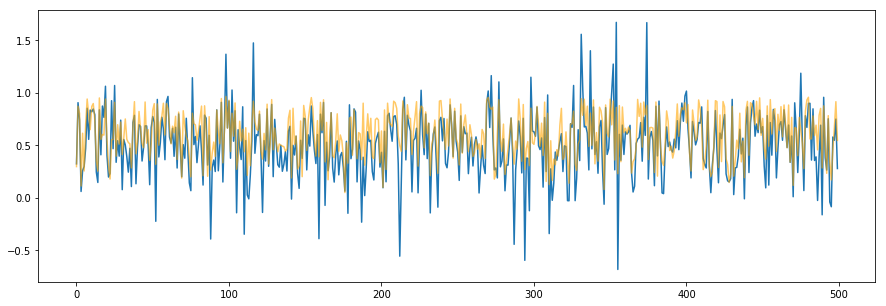

In [22]:
m =500
y_hat = [d[0] for d in model.predict([X_test_p[:m], X_test_bb[:m], X_test_rsi[:m]])]
y = y_test[:m]
print(score(y, y_hat))
plt.figure(figsize=(15,5))
plt.plot(y)
plt.plot(y_hat, color='orange', alpha=0.6)

## Plots / tests

In [1]:
from keras.models import load_model
model = load_model('models/size20future1_110219.h5')

Using TensorFlow backend.


In [7]:
int(model.input.shape[1])

20

In [175]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

class portfolio:
    def __init__(self, start_amount: float, model, fee=0.04):
        assert start_amount > 0, 'Want to play with no money?'
        self.start_amount = start_amount
        self.budget = start_amount  # dolars
        self.coins = 0
        self.fee = fee
        self.model = model
        self.history = []
        self.last_buy = 0

    def _process(self, window: pd.DataFrame):
        M = np.max(window.high.values)
        m = np.min(window.low.values)
        d = M - m
        output = (window.iloc[:,:-1] - m) / d
        vol = window.volume.values
        vol = (vol - np.min(vol))/(np.max(vol) - np.min(vol))
        assert output.shape[0] == vol.size, "Candles and volume sizes differ"
        output = np.array([np.concatenate([o, [x]]) for o, x in zip(output.values, vol)])
        
        return output, M, m

    def _reshape(self, window: pd.DataFrame, size):
        return window.values.reshape(size, 4)

    def _rescale(self, predicted_price, M, m):
        return (M - m) * predicted_price + m

    def _buy(self, price):
        self.coins = self.budget / price * (1 - self.fee)
        self.budget = 0
        self.last_buy = price

    def _sell(self, price):
        self.budget = self.coins * price * (1 - self.fee)
        self.coins = 0

    def _decide(self, price, prediction, epoch):
        if prediction >= price and self.coins == 0:
#             trade_cost = self.budget * self.fee
#             potential_profit = self.budget * (prediction - price)
#             if potential_profit > trade_cost:
            if (prediction/price - 1) > 0.01:
                self._buy(price)
                print(f'Epoch: {epoch} : BUY - actual: {price} predicted: {prediction}')
                self.history.append(('buy', price, prediction, self.coins, self.budget))

        if prediction < price and self.coins != 0:
#             trade_cost = self.coins * price * self.fee
#             potentail_loss = self.coins * (price - prediction)
#             if potentail_loss > trade_cost:
            if prediction < self.last_buy * 0.99:
                self._sell(price)
                print(f'Epoch: {epoch} : SELL - actual: {price} predicted: {prediction}')
                self.history.append(('sell', price, prediction, self.coins, self.budget))

    def simulate(self, df: pd.DataFrame):
        size = self.model.input_shape[1]
        # TODO: assert smth ! !
        y, y_hat = [], []
        self.epochs = df.shape[0] - size
        for i in range(self.epochs):
            window = df.iloc[i:i + size, :]
            recent_price = window.close.values[-1]
            output, M, m = self._process(window)
#             output = self._reshape(output, size)

            predicted_price = self.model.predict([[output]])[0][0]
            predicted_price = self._rescale(predicted_price, M, m)
            y.append(recent_price)
            y_hat.append(predicted_price)
            self._decide(recent_price, predicted_price, epoch=i)

        # make last trade
        if self.coins != 0:
            self._sell(recent_price)

        #  For plots
        self.y = y[1:]
        self.y_hat = y_hat

        self.summary()

    def summary(self):
        print('Portfolio summary')
        print(f'Transaction fee: {self.fee}')
        print(f'Start amount: {self.start_amount}')
        print(f'Final amount: {self.budget}')
        print(f'Earnings : {(self.budget - self.start_amount):.2f}')
        print(f'Profit : {100*(self.budget/self.start_amount -1):.2f}%')
        print(f'Decision points: {self.epochs}')
        print( f"Decisions made : {len(self.history)}, buy: {len([x for x in self.history if x[0]=='buy'])} sell: {len([x for x in self.history if x[0]=='sell'])}")

    def plot_history(self):
        coins = [x[3] for x in self.history if x[3] != 0]
        plt.plot(coins)
        plt.title('Coins history')
        plt.show()

        budget = [x[4] for x in self.history if x[4] != 0]
        plt.plot(budget)
        plt.title('Budget history')
        plt.show()

    def plot_prediction(self):
        plt.figure(figsize=(20,10))
        plt.plot(self.y)
        plt.plot(self.y_hat, color='orange')
        plt.show()
        
        

In [164]:
r = influx.query('SELECT * FROM LTCUSD1h ORDER BY time ASC;', epoch='s')
sample = pd.DataFrame(list(r.get_points(measurement='LTCUSD1h')))

,close,high,low,open,time,volume
0,86.690,86.868,86.164,86.164,1531976400,1607.988859
1,87.140,87.626,86.690,86.690,1531980000,5313.401498
2,86.340,87.245,86.251,87.041,1531983600,1627.098672
3,86.115,86.746,86.079,86.346,1531987200,2318.546876
4,87.643,87.858,86.086,86.144,1531990800,4207.205649


In [176]:
port = portfolio(1000, model, fee=0.004)

In [177]:
port.simulate(sample.iloc[:200,:][['close', 'open', 'high', 'low', 'volume']])

Epoch: 37 : BUY - actual: 82.101 predicted: 83.10841596829891
Portfolio summary
Transaction fee: 0.004
Start amount: 1000
Final amount: 997.4412102166842
Earnings : -2.56
Profit : -0.26%
Decision points: 148
Decisions made : 1, buy: 1 sell: 0


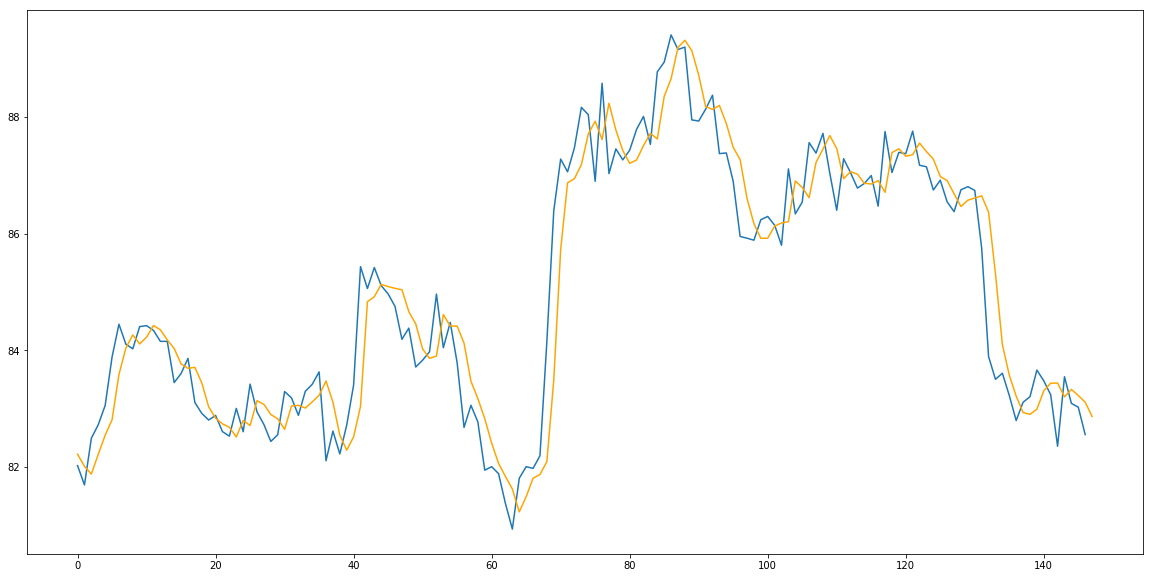

In [170]:
port.plot_prediction()

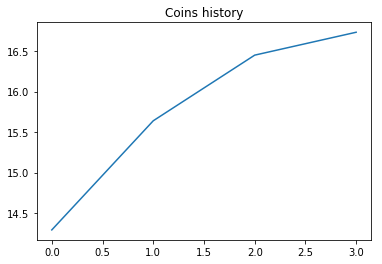

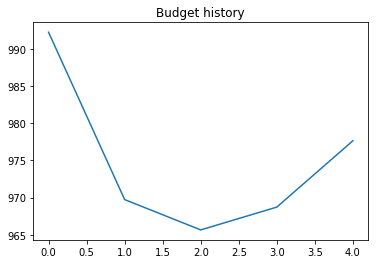

In [120]:
port.plot_history()

In [5]:
True+False == True

True